# Inverse dynamics optimization on real data
- This notebook is dedicated to testing the optimization process for inverse dynamics 
- Starting from a rough solution estimated by inverse kinematics
- No consideration of 2 projections is considered here (at least yet!)

:+1: Process either real or simulated data

In [81]:
import time 

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pinocchio as pin
from scipy.optimize import least_squares
from scipy.special import huber
from projectyl.utils.properties import ELBOW, SHOULDER, WRIST
from projectyl.utils.arm import plot_optimization_curves

from projectyl.dynamics.inverse_kinematics import build_arm_model
from projectyl.utils.arm import interactive_replay_sequence
from projectyl.utils.io import Dump
from projectyl.dynamics.inverse_dynamics import objective
from projectyl.dynamics.simulation import build_simulation
from interactive_pipe.helper import _private
_private.registered_controls_names = [] # this is for notebooks where you re-execute cells everytime.

SIMULATION = "simulation"
REAL = "real"

%load_ext autoreload
%autoreload 2
global_params = {}


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# :warning: PICK **REAL** or **SIMULATION**

In [82]:
# PICK SEQUENCE LENGTH HERE
T=80
# PICK UP THE MODE HERE
mode = SIMULATION
# mode = REAL
assert mode in [SIMULATION, REAL]

build_arm_model(global_params, headless=False, free_elbow=False)
arm_robot = global_params["arm"]
viz = global_params["viz"]

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


# SIMULATION


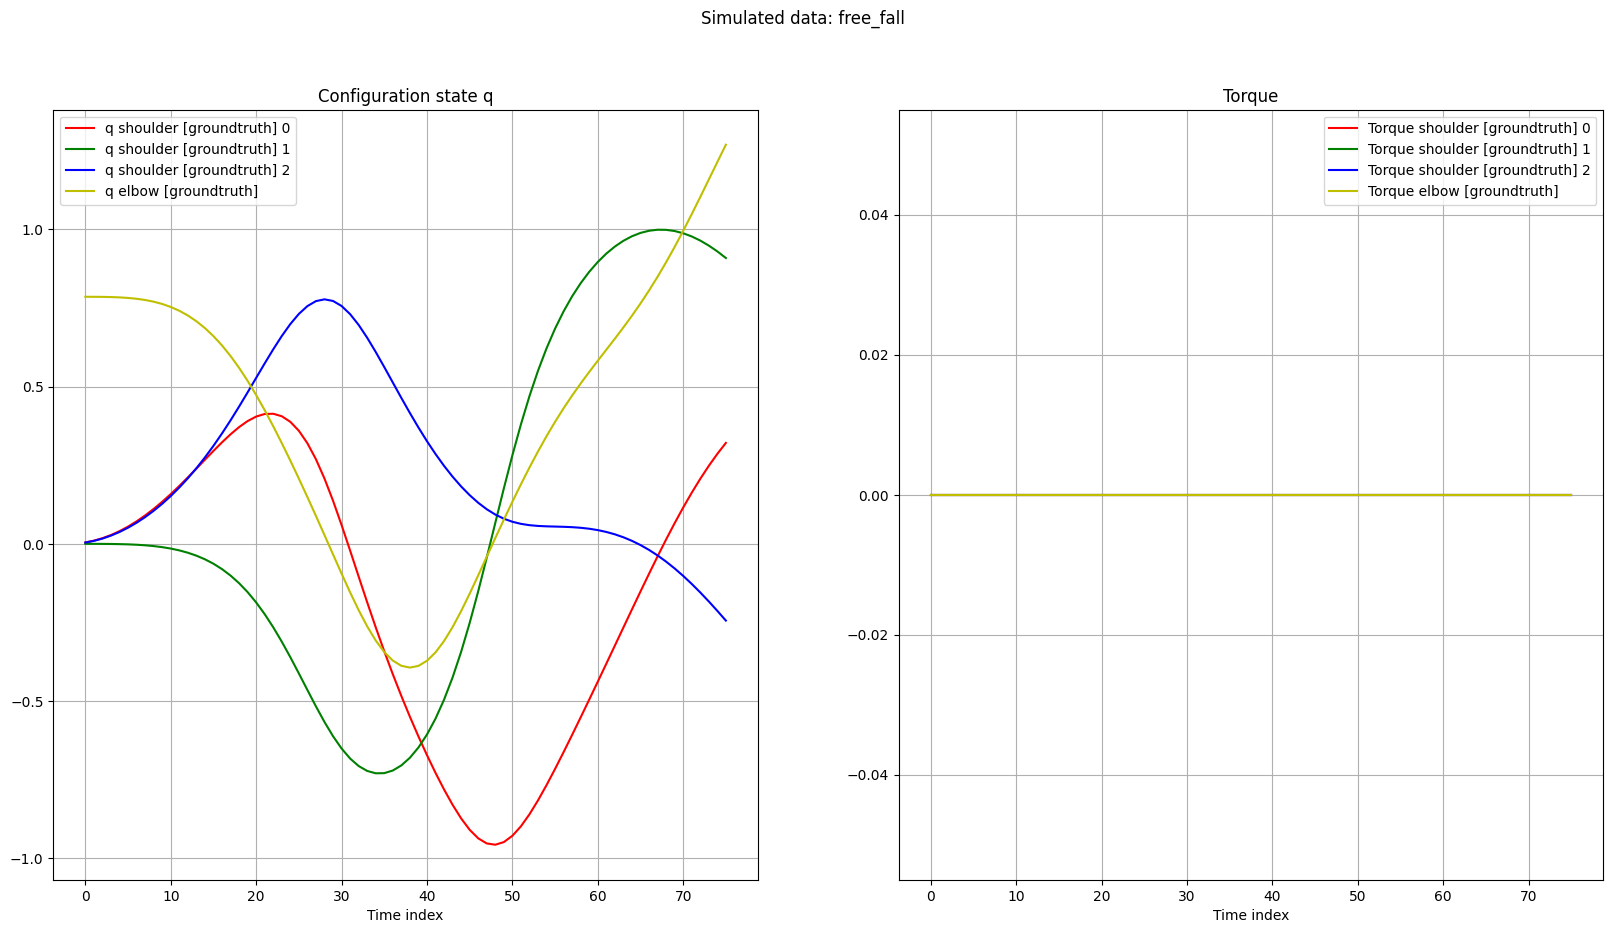

In [83]:
config = {
    "static": dict(static=True, friction_coefficient=None, initial_torque_modulation=0.),
    "friction" : dict(static=False, friction_coefficient=0.1, initial_torque_modulation=0.),
    "free_fall": dict(static=False, friction_coefficient=0., initial_torque_modulation=0.),
}
simu_modes = ["static", "friction", "free_fall"] # Pick the scenario you want to simulate here
simu_modes = ["free_fall",]
if mode == SIMULATION:
    for simu_mode in simu_modes:
        _private.registered_controls_names = [] # this is for notebooks where you re-execute cells everytime.
        # T_ORIGINAL = 30*3
        DT = 1e-2
        gt_q, gt_vq, gt_aq, gt_tauq, gt_shoulder_p, gt_elbow_p, gt_wrist_p = build_simulation(
            arm_robot,
            T=T,
            DT=DT,
            **config[simu_mode])

        # We will feed the optimiser with the foµllowing parameters
        # ground_truth_p = [p_shoulder_1, p_elbow_1, p_wrist_1, ..., p_shoulder_T, p_elbow_T, p_wrist_T], T and nq
        # The optimisation variable is
        # [q_1, q_2, ..., q_T, tauq_3, tauq_4, ..., tauq_T-2]

        gt_p = np.concatenate([
            np.concatenate([
                gt_shoulder_p[i], gt_elbow_p[i], gt_wrist_p[i]]
            ) for i in range(T)]
        )
        gt_qt = np.concatenate(gt_q + gt_tauq[2:-2])
        initial = gt_qt.copy()
        gt_full = np.concatenate([gt_q, gt_tauq], axis=1)
        init_res = np.concatenate([gt_q[:T], gt_tauq[:T]], axis=1) # For plots

        plot_optimization_curves([
            # (estimated_results[2:-2, :], "[estimated]", "--"),
            (gt_full[2:-2, :], "[groundtruth]", "-"),
            ],
            arm_robot.model.nq,
            title=f"Simulated data: {simu_mode}",
            mode="qt",
            fig_size=10
        )
else:
    print("Skipped, real data mode")

# REAL DATA
### Load data


To load data, you need a preprocessed video file. Assume IK has been performed first.

`python scripts/batch_video_processing.py -i "data/*9_*.mp4" -o __out -A ik --headless`

In [ ]:
if mode == REAL:
    data = Dump.load_pickle("../__out/0009_weight_lifting_main_camera_30fps/coarse_ik.pkl")

    # INITIAL STATE LIST
    q = np.array(data["q"])
    if T is None:
        T = len(q)

    # 3D points
    p = ([np.array([el.translation for el in data["3dpoints"][member]]).T for member in [SHOULDER, ELBOW, WRIST]])
    print(p[0].shape)
    gt_p_full = np.concatenate(p).T
    gt_p_full = gt_p_full[:T]
    print("Final shape", gt_p_full.shape) #T, 9

    # initialization from IK estimation
    initial_full = np.concatenate([q[:T].flatten(), np.zeros(((T-4), 4)).flatten()])
    initial_full.shape
    DT = 1/30. # 30fps
    print(initial_full.shape)
    initial = initial_full.flatten()
    gt_p = gt_p_full.flatten()
    init_res = np.concatenate([q[:T], np.zeros((T, 4))], axis=1) # For plots
else:
    print("Skipped, simulation mode")

# OPTIMIZE

In [86]:
debug= False
if mode == SIMULATION:
    coeffs=[1., 1E-8, 1E-8, 0.01, 2.] # Default config
    # coeffs=[1., 1E-4, 1E-4, 0.1, 2.] # Medium torque smoothing - suitable for free fall
    coeffs=[1., 0., 0., 0., 2.] # Not smoothing at all
elif mode == REAL:
    coeffs=[1., 1E-3, 1E-3, 0.01, 2.]
_sol = least_squares(objective, initial.flatten(), args=(gt_p, T, DT, arm_robot), kwargs={"debug": debug, "coeffs": coeffs}, method='lm').x
sol = _sol.copy()
# Extract the results
# First extract the T * nq configuration states
res_q = sol.copy()[:T*arm_robot.model.nq].reshape(T, -1)
q_norm = np.linalg.norm(res_q[:, :4], axis=1)
res_q[:, :4]/= q_norm.reshape(-1, 1)
# Extract the (T-4) * nv torque states
res_tauq = sol.copy()[T*arm_robot.model.nq:].reshape((T-4), -1)
# Concatenate the two
res_tauq = np.concatenate([np.zeros((2, arm_robot.model.nv)), res_tauq, np.zeros((2, arm_robot.model.nv))], axis=0)
res_q.shape, res_tauq.shape
estimated_results = np.concatenate([res_q, res_tauq], axis=1)
# Check the errors
print(">>>>>>> Initial error", np.linalg.norm(objective(initial, gt_p, T, DT, arm_robot, True)[0]))
print(">>>>>>> Optimization error", np.linalg.norm(objective(sol, gt_p, T, DT, arm_robot, True)[0]))

80, 0.01, var = (704,), observed_p = (720,)
Diff between 3D pose : 1.4860623289183306e-15
Smooth velocity : 24.13627087739132
Smooth acceleration : 265.03865865296973
Smooth torque : 0.0
Dynamics : 0.7737409502616326
>>>>>>> Initial error 1.5474819005255533
80, 0.01, var = (704,), observed_p = (720,)
Diff between 3D pose : 2.0340551928964447e-15
Smooth velocity : 24.13627087739132
Smooth acceleration : 265.03865865296984
Smooth torque : 0.7737409502616895
Dynamics : 1.2642826670442983e-12
>>>>>>> Optimization error 0.007737409960315612


# Plot curves

80, 0.01, var = (704,), observed_p = (720,)
Diff between 3D pose : 2.0340551928964447e-15
Smooth velocity : 24.13627087739132
Smooth acceleration : 265.03865865296984
Smooth torque : 0.7737409502616895
Dynamics : 1.2642826670442983e-12
Torque error: 0.06756697841464418


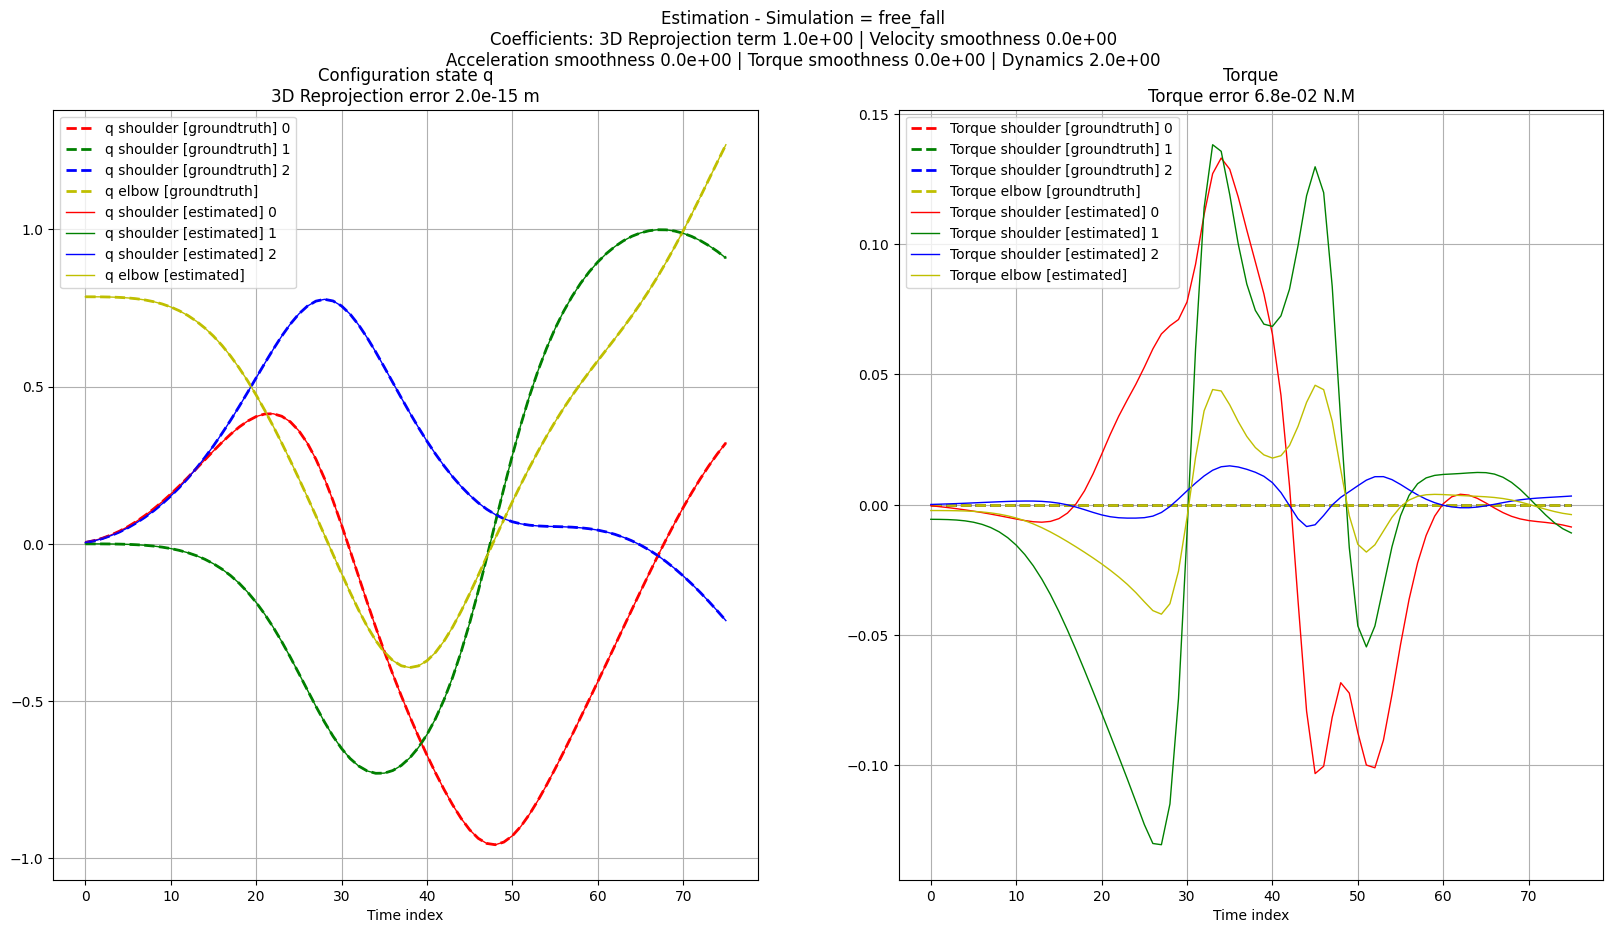

In [91]:
optim_conf = f"Coefficients: 3D Reprojection term {coeffs[0]:.1e} | Velocity smoothness {coeffs[1]:.1e}\n"
optim_conf+= f"Acceleration smoothness {coeffs[2]:.1e}"
optim_conf+= f" | Torque smoothness {coeffs[3]:.1e} | Dynamics {coeffs[4]:.1e}"
_private.registered_controls_names = [] # this is for notebooks where you re-execute cells everytime.
if mode == SIMULATION:
    _, reproj, tau_estim = objective(sol, gt_p, T, DT, arm_robot, True)
    torque_error = np.linalg.norm(tau_estim.reshape(T-4, -1) - np.array(gt_tauq)[2:-2], axis=1).mean()
    print("Torque error:", torque_error)
    plot_optimization_curves([
        (gt_full[2:-2, :], "[groundtruth]", "--", 2),
        (estimated_results[2:-2, :], "[estimated]", "-", 1),
        ],
        arm_robot.model.nq,
        title="Estimation - " + f"Simulation = {simu_mode}\n{optim_conf}",
        mode="qt",
        q_title=f"\n3D Reprojection error {reproj:.1e} m",
        t_title=f"\nTorque error {torque_error:.1e} N.M",
        fig_size=10
    )
else:
    plot_optimization_curves([
    (init_res[2:-2, :], "[initial]", "--", 2,),
    # (gt_full[2:-2, :], "[groundtruth]", "--"),
    (estimated_results[2:-2, :], "[estimated]", "-", 1),
    ],
    arm_robot.model.nq,
    title="Estimation - Real data",
    mode="qt",
    fig_size=10
)


# Replay the motion interactively

In [ ]:
sequence_replay = {
        "estimated": estimated_results[:, :arm_robot.model.nq],
        "initial": init_res[:, :arm_robot.model.nq],
}
if mode == SIMULATION:
    sequence_replay["groundtruth"] = gt_full[:, :arm_robot.model.nq]
interactive_replay_sequence(
    sequence_replay,
    viz
)